## <CENTER>         IMAGE  FORGERY  DETECTION USING CONVOLUTIONAL NEURAL NETWORK

### ABSTRACT

Image forgery detection is a critical task in digital forensics and security, aiming to identify whether an image has been tampered with or manipulated. In this project, developed a deep learning-based approach for image forgery detection using Convolutional Neural Networks (CNNs) and transfer learning techniques. The dataset used for training and evaluation consists of authentic and tampered images from the CASIA Dataset.  Employed Error Level Analysis (ELA) to preprocess the images, enhancing the differences between original and manipulated regions.

The proposed model architecture consists of convolutional layers followed by max-pooling, dropout layers for regularization, and fully connected layers for classification. Iam trained the model using binary cross-entropy loss and Adam optimizer. Additionally, utilized data augmentation techniques to enhance model generalization and mitigate overfitting.

Experimental results demonstrate the effectiveness of the proposed approach in accurately distinguishing between authentic and tampered images.And achieved competitive performance metrics, including accuracy evaluated through confusion matrices and classification reports. Furthermore, I compared the performance of our model with a transfer learning-based approach using the DenseNet121 architecture, showcasing the adaptability and robustness of deep learning frameworks in image forgery detection tasks.

## Importing Libraries 

In [2]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense,Dropout
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
from PIL import Image,ImageChops,ImageEnhance
import os
import itertools

## Data Preprocessing

In [4]:
from glob import glob
total_files=glob("CASIA Dataset/train/**/*")
print(len(total_files))

12616


In [5]:
type=set()
for file in total_files:
    type.add(file.split(".")[-1])
print("Type of files are: ",type)

Type of files are:  {'jpg', 'tif', 'bmp', 'JPG', 'db'}


### Error Level Analysis (ELA)

In [6]:
def convert_to_ELA_image(path,quality):
    temp_file_name='temp_file_name.jpg'
    ela_file_name='temp_ela.png'
    
    image=Image.open(path).convert('RGB')
    image.save(temp_file_name,'JPEG',quality=quality)
    temp_image=Image.open(temp_file_name)
    
    ela_image=ImageChops.difference(image,temp_image)
    
    extrema=ela_image.getextrema()
    max_diff=max([ex[1] for ex in extrema])
    if max_diff==0:
        max_diff=1
    scale=255.0/max_diff
    
    ela_image=ImageEnhance.Brightness(ela_image).enhance(scale)
    return ela_image

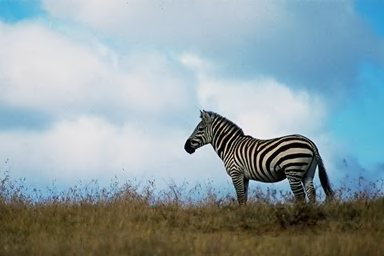

In [7]:
real_image_path="CASIA Dataset/train/Authentic/Au_ani_00001.jpg"
Image.open(real_image_path)

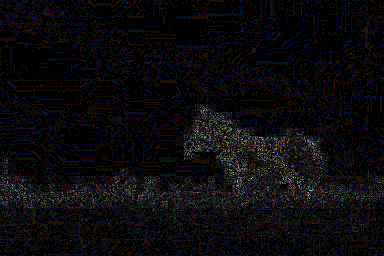

In [8]:
convert_to_ELA_image(real_image_path,90)

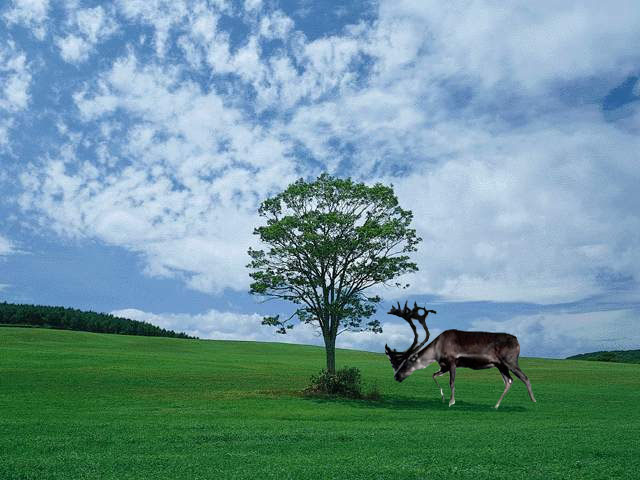

In [9]:
fake_image_path="CASIA Dataset/train/Tampered/Tp_D_CNN_M_N_nat10156_ani00024_12016.jpg"
Image.open(fake_image_path)

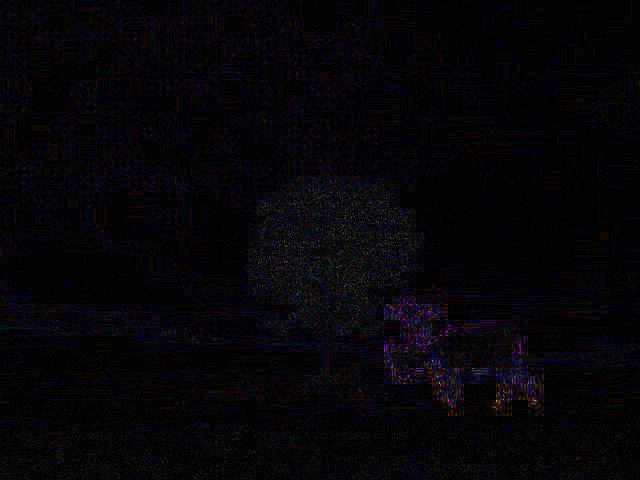

In [10]:
convert_to_ELA_image(fake_image_path,90)

### Prepare Image Data

In [11]:
image_size=(128,128)

In [12]:
def prepare_image(image_path):
    return np.array(convert_to_ELA_image(image_path,90).resize(image_size)).flatten()/255.0

In [13]:
X=[] #ELA coverted image
Y=[] # 0 for tampered and 1 for real

In [15]:
import random
path="CASIA Dataset/train/Authentic"

for dir_name, _,file_names in os.walk(path):
    for file_name in file_names:
        if file_name.endswith('jpg') or file_name.endswith('png') or file_name.endswith('tif'):
            full_path=os.path.join(dir_name,file_name)
            X.append(prepare_image(full_path))
            Y.append(1)
            
            if len(Y) % 500==0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:2500]  
Y = Y[:2500] 

print(len(X),len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
2500 2500


In [16]:
path="CASIA Dataset/train/Tampered"
for dir_name, _,file_names in os.walk(path):
    for file_name in file_names:
        if file_name.endswith('jpg') or file_name.endswith('png') or file_name.endswith('tif'):
            
            full_path=os.path.join(dir_name,file_name)
            X.append(prepare_image(full_path))
            Y.append(0)
            
            if len(Y) % 500==0:
                print(f'Processing {len(Y)} images')
    
print(len(X),len(Y))

Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
Processing 7500 images
7623 7623


In [17]:
X=np.array(X)
Y=to_categorical(Y,2)
X=X.reshape(-1,128,128,3)

In [18]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,random_state=42)

X=X.reshape(-1,1,1,1)

print(len(X_train),len(Y_train))
print(len(X_test),len(Y_test))

6098 6098
1525 1525


## Build Convolutional Neural Network (CNN) Model

In [19]:
def build_model():
    
    model=Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='valid', activation='relu',input_shape=(128,128,3)))
    
    model.add(Conv2D(filters=32, kernel_size=(5,5), padding='valid', activation='relu',input_shape=(128,128,3)))
    
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(2,activation='sigmoid'))
    
    return model
    

In [20]:
model=build_model()
model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 60, 60, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 flatten (Flatten)           (None, 115200)            0         
                                                                 
 dense (Dense)               (None, 256)               29491456  
                                                      

In [21]:
epochs=100
batch_size=32

In [22]:
init_learning_rate=1e-4
optimizer=Adam(learning_rate=init_learning_rate)

### Compiling The Model

In [23]:
model.compile(optimizer=optimizer,loss='binary_crossentropy',metrics=['accuracy'])

In [24]:
#define callbacks
checkpoint=ModelCheckpoint("forgery_model.keras",
                           monitor='val_loss',
                           mode='min',
                           save_best_only=True,
                           verbose=1)
early_stopping=EarlyStopping(monitor='val_loss',
                             patience=5,
                             restore_best_weights=True,
                             verbose=1)

## Model Training

In [25]:
%%time
hist=model.fit(
              X_train,
              Y_train,
              batch_size=batch_size,
              epochs=epochs,
              validation_data=(X_test,Y_test),
              callbacks=[checkpoint,early_stopping])

Epoch 1/100


191/191 [==============================] - ETA: 0s - loss: 0.4447 - accuracy: 0.8301
Epoch 1: val_loss improved from inf to 0.35016, saving model to forgery_model.keras
191/191 [==============================] - 140s 718ms/step - loss: 0.4447 - accuracy: 0.8301 - val_loss: 0.3502 - val_accuracy: 0.8885
Epoch 2/100
191/191 [==============================] - ETA: 0s - loss: 0.3178 - accuracy: 0.9026
Epoch 2: val_loss improved from 0.35016 to 0.29032, saving model to forgery_model.keras
191/191 [==============================] - 125s 654ms/step - loss: 0.3178 - accuracy: 0.9026 - val_loss: 0.2903 - val_accuracy: 0.9108
Epoch 3/100
191/191 [==============================] - ETA: 0s - loss: 0.2738 - accuracy: 0.9152
Epoch 3: val_loss did not improve from 0.29032
191/191 [==============================] - 118s 616ms/step - loss: 0.2738 - accuracy: 0.9152 - val_loss: 0.3247 - val_accuracy: 0.8728
Epoch 4/100
191/191 [==============================] - ETA: 0s - loss: 0.2418 - acc

## Model Evaluation and Visualization

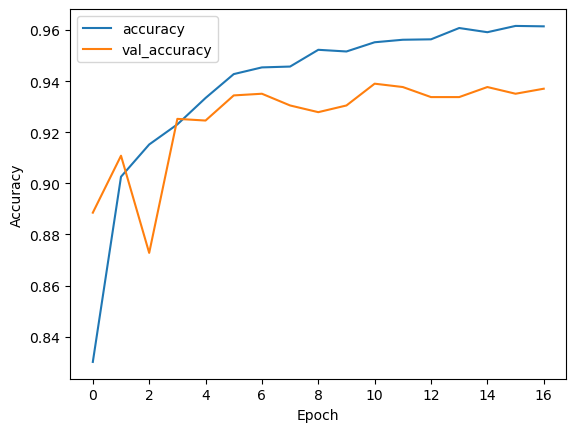

In [26]:
# Plotting CNN Model History
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

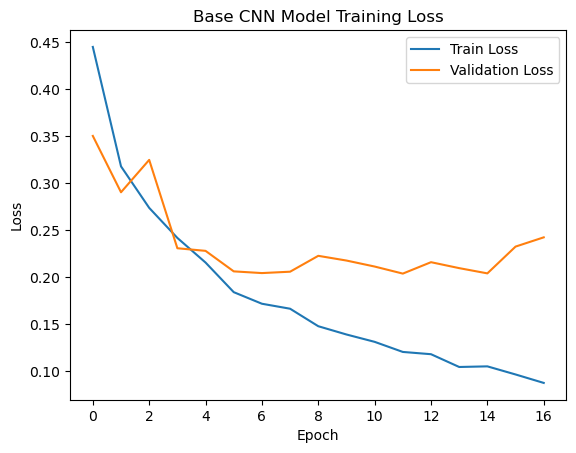

In [27]:
plt.plot(hist.history['loss'], label='Train Loss')
plt.plot(hist.history['val_loss'] , label='Validation Loss')
plt.title('Base CNN Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
loss,accuracy=model.evaluate(X_test, Y_test,batch_size=32)

48/48 [==============================] - 7s 140ms/step - loss: 0.2039 - accuracy: 0.9377


### Confusion Matrix

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

48/48 [==============================] - 7s 129ms/step


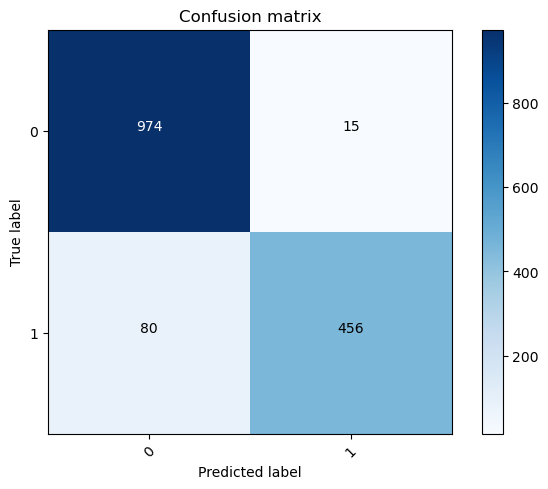

In [30]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_test,axis = 1) 

# compute the confusion matrix
confusion_matrix_array = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_matrix_array, classes = range(2))

In [31]:
class_names=['Tampered','Authentic']

### Individual Image Prediction

In [32]:
real_image_path="CASIA Dataset/train/Authentic/Au_ani_00001.jpg"
image=prepare_image(real_image_path)
image=image.reshape(-1,128,128,3)

y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]

print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 109ms/step
Class: Authentic Confidence: 97.36


In [33]:
fake_image_path = "CASIA Dataset/train/Tampered/Tp_D_CNN_M_N_nat10156_ani00024_12016.jpg"
image = prepare_image(fake_image_path)
image = image.reshape(-1, 128, 128, 3)
y_pred = model.predict(image)
y_pred_class = np.argmax(y_pred, axis = 1)[0]
print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 60ms/step
Class: Tampered Confidence: 97.42


### Overall Model Evaluation

In [34]:
fake_image = os.listdir("CASIA Dataset/train/Tampered")
correct = 0
total = 0
for file_name in fake_image:
    if file_name.endswith('jpg') or file_name.endswith('png') or file_name.endswith('tif'):
        fake_image_path = os.path.join("CASIA Dataset/train/Tampered", file_name)
        image = prepare_image(fake_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total += 1
        if y_pred_class == 0:
            correct += 1
            print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.99
1/1 [==============================] - 0s 42ms/step
Class: Tampered Confidence: 99.88
1/1 [==============================] - 0s 36ms/step
Class: Tampered Confidence: 96.43
1/1 [==============================] - 0s 37ms/step
Class: Tampered Confidence: 97.77
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 99.97
1/1 [==============================] - 0s 36ms/step
Class: Tampered Confidence: 99.23
1/1 [==============================] - 0s 42ms/step
Class: Tampered Confidence: 100.00
1/1 [==============================] - 0s 42ms/step
Class: Tampered Confidence: 90.79
1/1 [==============================] - 0s 42ms/step
Class: Tampered Confidence: 89.16
1/1 [==============================] - 0s 42ms/step
Class: Tampered Confidence: 99.72
1/1 [==============================] - 0s 51ms/step
Class: Tampered Confidence: 98.12
1/1 [==============================] - 0s 42ms/step
C

1/1 [==============================] - 0s 50ms/step
Class: Tampered Confidence: 96.53
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 98.00
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 98.37
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 98.94
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 99.72
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.68
1/1 [==============================] - 0s 40ms/step
Class: Tampered Confidence: 96.58
1/1 [==============================] - 0s 40ms/step
Class: Tampered Confidence: 94.15
1/1 [==============================] - 0s 39ms/step
Class: Tampered Confidence: 97.72
1/1 [==============================] - 0s 37ms/step
Class: Tampered Confidence: 99.38
1/1 [==============================] - 0s 37ms/step
Class: Tampered Confidence: 99.84
1/1 [==============================] - 0s 37ms/step
Cl

1/1 [==============================] - 0s 25ms/step
Class: Tampered Confidence: 99.38
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 89.23
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 91.10
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.78
1/1 [==============================] - 0s 42ms/step
Class: Tampered Confidence: 99.93
1/1 [==============================] - 0s 25ms/step
Class: Tampered Confidence: 99.98
1/1 [==============================] - 0s 37ms/step
Class: Tampered Confidence: 99.47
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 98.71
1/1 [==============================] - 0s 37ms/step
Class: Tampered Confidence: 94.35
1/1 [==============================] - 0s 35ms/step
Class: Tampered Confidence: 96.80
1/1 [==============================] - 0s 51ms/step
Class: Tampered Confidence: 99.94
1/1 [==============================] - 0s 52ms/step
Cl

1/1 [==============================] - 0s 59ms/step
Class: Tampered Confidence: 99.67
1/1 [==============================] - 0s 39ms/step
Class: Tampered Confidence: 99.75
1/1 [==============================] - 0s 39ms/step
Class: Tampered Confidence: 96.98
1/1 [==============================] - 0s 25ms/step
Class: Tampered Confidence: 99.70
1/1 [==============================] - 0s 37ms/step
Class: Tampered Confidence: 99.93
1/1 [==============================] - 0s 32ms/step
Class: Tampered Confidence: 99.55
1/1 [==============================] - 0s 35ms/step
Class: Tampered Confidence: 99.88
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 78.40
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 96.87
1/1 [==============================] - 0s 35ms/step
Class: Tampered Confidence: 98.37
1/1 [==============================] - 0s 36ms/step
Class: Tampered Confidence: 98.56
1/1 [==============================] - 0s 40ms/step
Cl

1/1 [==============================] - 0s 25ms/step
Class: Tampered Confidence: 90.73
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 95.35
1/1 [==============================] - 0s 26ms/step
Class: Tampered Confidence: 97.66
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 98.77
1/1 [==============================] - 0s 48ms/step
Class: Tampered Confidence: 99.15
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.09
1/1 [==============================] - 0s 49ms/step
Class: Tampered Confidence: 99.23
1/1 [==============================] - 0s 40ms/step
Class: Tampered Confidence: 97.62
1/1 [==============================] - 0s 32ms/step
Class: Tampered Confidence: 95.94
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 99.94
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 99.66
1/1 [==============================] - 0s 33ms/step
Cl

1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 87.93
1/1 [==============================] - 0s 42ms/step
Class: Tampered Confidence: 95.33
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 99.63
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.37
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.53
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.97
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.40
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.32
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.49
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 99.73
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 99.60
1/1 [==============================] - 0s 34ms/step
Cl

1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 98.97
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 97.57
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 98.86
1/1 [==============================] - 0s 26ms/step
Class: Tampered Confidence: 97.18
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.50
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 97.37
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 96.54
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 92.52
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 97.07
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.06
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 63.01
1/1 [==============================] - 0s 45ms/step
Cl

1/1 [==============================] - 0s 51ms/step
Class: Tampered Confidence: 93.94
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 97.87
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 98.97
1/1 [==============================] - 0s 37ms/step
Class: Tampered Confidence: 97.00
1/1 [==============================] - 0s 31ms/step
Class: Tampered Confidence: 94.54
1/1 [==============================] - 0s 37ms/step
Class: Tampered Confidence: 97.53
1/1 [==============================] - 0s 25ms/step
Class: Tampered Confidence: 95.84
1/1 [==============================] - 0s 37ms/step
Class: Tampered Confidence: 99.35
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 98.80
1/1 [==============================] - 0s 50ms/step
Class: Tampered Confidence: 84.78
1/1 [==============================] - 0s 42ms/step
Class: Tampered Confidence: 100.00
1/1 [==============================] - 0s 46ms/step
C

1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 88.15
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.46
1/1 [==============================] - 0s 25ms/step
Class: Tampered Confidence: 94.74
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 96.98
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 99.96
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 98.86
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 90.73
1/1 [==============================] - 0s 36ms/step
Class: Tampered Confidence: 93.58
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 77.32
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 94.03
1/1 [==============================] - 0s 42ms/step
Class: Tampered Confidence: 97.86
1/1 [==============================] - 0s 38ms/step
Cl

1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 99.30
1/1 [==============================] - 0s 25ms/step
Class: Tampered Confidence: 99.37
1/1 [==============================] - 0s 42ms/step
Class: Tampered Confidence: 94.56
1/1 [==============================] - 0s 66ms/step
Class: Tampered Confidence: 97.77
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 97.63
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 98.88
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 98.79
1/1 [==============================] - 0s 59ms/step
Class: Tampered Confidence: 98.54
1/1 [==============================] - 0s 54ms/step
Class: Tampered Confidence: 95.18
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 98.18
1/1 [==============================] - 0s 67ms/step
Class: Tampered Confidence: 92.07
1/1 [==============================] - 0s 50ms/step
Cl

1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.88
1/1 [==============================] - 0s 25ms/step
Class: Tampered Confidence: 86.54
1/1 [==============================] - 0s 52ms/step
Class: Tampered Confidence: 96.47
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 91.59
1/1 [==============================] - 0s 42ms/step
Class: Tampered Confidence: 83.62
1/1 [==============================] - 0s 53ms/step
Class: Tampered Confidence: 96.62
1/1 [==============================] - 0s 56ms/step
Class: Tampered Confidence: 99.48
1/1 [==============================] - 0s 61ms/step
Class: Tampered Confidence: 99.93
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 93.98
1/1 [==============================] - 0s 42ms/step
Class: Tampered Confidence: 100.00
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.99
1/1 [==============================] - 0s 34ms/step
C

1/1 [==============================] - 0s 47ms/step
Class: Tampered Confidence: 90.08
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 98.22
1/1 [==============================] - 0s 50ms/step
Class: Tampered Confidence: 100.00
1/1 [==============================] - 0s 58ms/step
Class: Tampered Confidence: 96.54
1/1 [==============================] - 0s 54ms/step
Class: Tampered Confidence: 77.44
1/1 [==============================] - 0s 51ms/step
Class: Tampered Confidence: 93.86
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.97
1/1 [==============================] - 0s 40ms/step
Class: Tampered Confidence: 93.43
1/1 [==============================] - 0s 42ms/step
Class: Tampered Confidence: 99.45
1/1 [==============================] - 0s 38ms/step
Class: Tampered Confidence: 99.97
1/1 [==============================] - 0s 35ms/step
Class: Tampered Confidence: 98.34
1/1 [==============================] - 0s 35ms/step
C

1/1 [==============================] - 0s 31ms/step
Class: Tampered Confidence: 99.40
1/1 [==============================] - 0s 28ms/step
Class: Tampered Confidence: 99.76
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.73
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.90
1/1 [==============================] - 0s 59ms/step
Class: Tampered Confidence: 99.95
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.98
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 95.45
1/1 [==============================] - 0s 50ms/step
Class: Tampered Confidence: 95.29
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 97.85
1/1 [==============================] - 0s 59ms/step
Class: Tampered Confidence: 95.05
1/1 [==============================] - 0s 32ms/step
Class: Tampered Confidence: 99.11
1/1 [==============================] - 0s 32ms/step
Cl

1/1 [==============================] - 0s 41ms/step
Class: Tampered Confidence: 99.68
1/1 [==============================] - 0s 35ms/step
Class: Tampered Confidence: 99.97
1/1 [==============================] - 0s 37ms/step
Class: Tampered Confidence: 100.00
1/1 [==============================] - 0s 38ms/step
Class: Tampered Confidence: 99.99
1/1 [==============================] - 0s 36ms/step
Class: Tampered Confidence: 99.93
1/1 [==============================] - 0s 36ms/step
Class: Tampered Confidence: 99.76
1/1 [==============================] - 0s 43ms/step
Class: Tampered Confidence: 99.94
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 96.82
1/1 [==============================] - 0s 43ms/step
Class: Tampered Confidence: 99.97
1/1 [==============================] - 0s 41ms/step
Class: Tampered Confidence: 99.44
1/1 [==============================] - 0s 32ms/step
Class: Tampered Confidence: 99.98
1/1 [==============================] - 0s 35ms/step
C

1/1 [==============================] - 0s 28ms/step
Class: Tampered Confidence: 98.33
1/1 [==============================] - 0s 36ms/step
Class: Tampered Confidence: 99.99
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 99.98
1/1 [==============================] - 0s 46ms/step
Class: Tampered Confidence: 98.69
1/1 [==============================] - 0s 36ms/step
Class: Tampered Confidence: 90.33
1/1 [==============================] - 0s 55ms/step
Class: Tampered Confidence: 99.47
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.57
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.86
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.93
1/1 [==============================] - 0s 32ms/step
Class: Tampered Confidence: 98.94
1/1 [==============================] - 0s 38ms/step
Class: Tampered Confidence: 99.67
1/1 [==============================] - 0s 39ms/step
Cl

1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 96.55
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.85
1/1 [==============================] - 0s 39ms/step
Class: Tampered Confidence: 99.79
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.28
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 100.00
1/1 [==============================] - 0s 42ms/step
Class: Tampered Confidence: 99.95
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 98.92
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 99.95
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.91
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.50
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.47
1/1 [==============================] - 0s 43ms/step
C

1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 90.13
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 89.60
1/1 [==============================] - 0s 67ms/step
Class: Tampered Confidence: 99.77
1/1 [==============================] - 0s 42ms/step
Class: Tampered Confidence: 97.30
1/1 [==============================] - 0s 50ms/step
Class: Tampered Confidence: 99.99
1/1 [==============================] - 0s 41ms/step
Class: Tampered Confidence: 100.00
1/1 [==============================] - 0s 42ms/step
Class: Tampered Confidence: 99.99
1/1 [==============================] - 0s 42ms/step
Class: Tampered Confidence: 95.47
1/1 [==============================] - 0s 42ms/step
Class: Tampered Confidence: 94.53
1/1 [==============================] - 0s 40ms/step
Class: Tampered Confidence: 78.79
1/1 [==============================] - 0s 25ms/step
Class: Tampered Confidence: 88.51
1/1 [==============================] - 0s 35ms/step
C

1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 89.92
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 93.70
1/1 [==============================] - 0s 24ms/step
Class: Tampered Confidence: 83.26
1/1 [==============================] - 0s 37ms/step
Class: Tampered Confidence: 96.03
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 94.87
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 77.80
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 98.09
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 92.05
1/1 [==============================] - 0s 67ms/step
Class: Tampered Confidence: 97.48
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 99.07
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 98.31
1/1 [==============================] - 0s 25ms/step
Cl

Class: Tampered Confidence: 98.86
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.77
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.85
1/1 [==============================] - 0s 25ms/step
Class: Tampered Confidence: 99.90
1/1 [==============================] - 0s 59ms/step
Class: Tampered Confidence: 99.98
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 98.85
1/1 [==============================] - 0s 36ms/step
Class: Tampered Confidence: 87.21
1/1 [==============================] - 0s 36ms/step
Class: Tampered Confidence: 99.75
1/1 [==============================] - 0s 52ms/step
Class: Tampered Confidence: 99.85
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.59
1/1 [==============================] - 0s 38ms/step
Class: Tampered Confidence: 98.67
1/1 [==============================] - 0s 50ms/step
Class: Tampered Confidence: 99.66
1/1 [===============

1/1 [==============================] - 0s 24ms/step
Class: Tampered Confidence: 85.62
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 93.16
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 99.57
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 89.05
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 95.05
1/1 [==============================] - 0s 51ms/step
Class: Tampered Confidence: 98.95
1/1 [==============================] - 0s 42ms/step
Class: Tampered Confidence: 93.24
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 93.16
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 84.33
1/1 [==============================] - 0s 43ms/step
Class: Tampered Confidence: 95.75
1/1 [==============================] - 0s 42ms/step
Class: Tampered Confidence: 79.92
1/1 [==============================] - 0s 25ms/step
Cl

1/1 [==============================] - 0s 37ms/step
Class: Tampered Confidence: 83.04
1/1 [==============================] - 0s 37ms/step
Class: Tampered Confidence: 73.40
1/1 [==============================] - 0s 35ms/step
Class: Tampered Confidence: 73.01
1/1 [==============================] - 0s 35ms/step
Class: Tampered Confidence: 95.45
1/1 [==============================] - 0s 41ms/step
Class: Tampered Confidence: 89.78
1/1 [==============================] - 0s 72ms/step
Class: Tampered Confidence: 87.31
1/1 [==============================] - 0s 55ms/step
Class: Tampered Confidence: 96.09
1/1 [==============================] - 0s 40ms/step
Class: Tampered Confidence: 96.28
1/1 [==============================] - 0s 37ms/step
Class: Tampered Confidence: 78.41
1/1 [==============================] - 0s 47ms/step
Class: Tampered Confidence: 72.52
1/1 [==============================] - 0s 35ms/step
Class: Tampered Confidence: 85.53
1/1 [==============================] - 0s 36ms/step
Cl

1/1 [==============================] - 0s 27ms/step
Class: Tampered Confidence: 82.63
1/1 [==============================] - 0s 25ms/step
Class: Tampered Confidence: 82.18
1/1 [==============================] - 0s 40ms/step
Class: Tampered Confidence: 91.72
1/1 [==============================] - 0s 31ms/step
Class: Tampered Confidence: 86.61
1/1 [==============================] - 0s 25ms/step
Class: Tampered Confidence: 86.66
1/1 [==============================] - 0s 35ms/step
Class: Tampered Confidence: 86.46
1/1 [==============================] - 0s 42ms/step
Class: Tampered Confidence: 98.99
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 98.75
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 95.40
1/1 [==============================] - 0s 29ms/step
Class: Tampered Confidence: 99.39
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.19
1/1 [==============================] - 0s 32ms/step
Cl

1/1 [==============================] - 0s 62ms/step
Class: Tampered Confidence: 99.40
1/1 [==============================] - 0s 52ms/step
Class: Tampered Confidence: 99.94
1/1 [==============================] - 0s 51ms/step
Class: Tampered Confidence: 99.89
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 99.97
1/1 [==============================] - 0s 37ms/step
Class: Tampered Confidence: 99.83
1/1 [==============================] - 0s 36ms/step
Class: Tampered Confidence: 99.79
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 99.88
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.95
1/1 [==============================] - 0s 52ms/step
Class: Tampered Confidence: 99.85
1/1 [==============================] - 0s 68ms/step
Class: Tampered Confidence: 99.72
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 99.85
1/1 [==============================] - 0s 34ms/step
Cl

1/1 [==============================] - 0s 42ms/step
Class: Tampered Confidence: 99.97
1/1 [==============================] - 0s 43ms/step
Class: Tampered Confidence: 100.00
1/1 [==============================] - 0s 51ms/step
Class: Tampered Confidence: 99.63
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 99.80
1/1 [==============================] - 0s 43ms/step
Class: Tampered Confidence: 99.79
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.58
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.95
1/1 [==============================] - 0s 25ms/step
Class: Tampered Confidence: 100.00
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 99.74
1/1 [==============================] - 0s 32ms/step
Class: Tampered Confidence: 99.87
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.77
1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 95.50
1/1 [==============================] - 0s 42ms/step
Class: Tampered Confidence: 97.97
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 100.00
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 92.10
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 98.77
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 97.07
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.74
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 99.75
1/1 [==============================] - 0s 35ms/step
Class: Tampered Confidence: 99.99
1/1 [==============================] - 0s 39ms/step
Class: Tampered Confidence: 99.98
1/1 [==============================] - 0s 42ms/step
Class: Tampered Confidence: 99.76
1/1 [==============================] - 0s 35ms/step
C

1/1 [==============================] - 0s 30ms/step
Class: Tampered Confidence: 95.92
1/1 [==============================] - 0s 38ms/step
Class: Tampered Confidence: 98.08
1/1 [==============================] - 0s 29ms/step
Class: Tampered Confidence: 99.38
1/1 [==============================] - 0s 25ms/step
Class: Tampered Confidence: 84.43
1/1 [==============================] - 0s 42ms/step
Class: Tampered Confidence: 94.40
1/1 [==============================] - 0s 51ms/step
Class: Tampered Confidence: 98.82
1/1 [==============================] - 0s 44ms/step
Class: Tampered Confidence: 96.52
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 74.81
1/1 [==============================] - 0s 56ms/step
Class: Tampered Confidence: 78.11
1/1 [==============================] - 0s 51ms/step
Class: Tampered Confidence: 94.50
1/1 [==============================] - 0s 41ms/step
Class: Tampered Confidence: 94.88
1/1 [==============================] - 0s 43ms/step
Cl

1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 94.74
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 90.82
1/1 [==============================] - 0s 37ms/step
Class: Tampered Confidence: 99.89
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 97.01
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 86.79
1/1 [==============================] - 0s 31ms/step
Class: Tampered Confidence: 84.72
1/1 [==============================] - 0s 40ms/step
Class: Tampered Confidence: 99.90
1/1 [==============================] - 0s 44ms/step
Class: Tampered Confidence: 99.98
1/1 [==============================] - 0s 52ms/step
Class: Tampered Confidence: 93.36
1/1 [==============================] - 0s 28ms/step
Class: Tampered Confidence: 99.00
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 98.10
1/1 [==============================] - 0s 34ms/step
Cl

1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 97.67
1/1 [==============================] - 0s 41ms/step
Class: Tampered Confidence: 72.44
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 99.97
1/1 [==============================] - 0s 36ms/step
Class: Tampered Confidence: 99.99
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 91.70
1/1 [==============================] - 0s 32ms/step
Class: Tampered Confidence: 96.89
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.10
1/1 [==============================] - 0s 51ms/step
Class: Tampered Confidence: 99.83
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 99.98
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 97.24
1/1 [==============================] - 0s 32ms/step
Class: Tampered Confidence: 91.98
1/1 [==============================] - 0s 34ms/step
Cl

1/1 [==============================] - 0s 43ms/step
Class: Tampered Confidence: 67.50
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 57.63
1/1 [==============================] - 0s 25ms/step
Class: Tampered Confidence: 97.81
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 97.41
1/1 [==============================] - 0s 63ms/step
Class: Tampered Confidence: 86.04
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 91.44
1/1 [==============================] - 0s 59ms/step
Class: Tampered Confidence: 94.31
1/1 [==============================] - 0s 35ms/step
Class: Tampered Confidence: 79.11
1/1 [==============================] - 0s 46ms/step
Class: Tampered Confidence: 86.91
1/1 [==============================] - 0s 43ms/step
Class: Tampered Confidence: 73.41
1/1 [==============================] - 0s 50ms/step
Class: Tampered Confidence: 99.92
1/1 [==============================] - 0s 35ms/step
Cl

1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 94.70
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 99.90
1/1 [==============================] - 0s 61ms/step
Class: Tampered Confidence: 99.89
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 99.87
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 99.99
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 99.34
1/1 [==============================] - 0s 32ms/step
Class: Tampered Confidence: 99.98
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 98.39
1/1 [==============================] - 0s 25ms/step
Class: Tampered Confidence: 97.58
1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 99.94
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 97.59
1/1 [==============================] - 0s 25ms/step
Cl

1/1 [==============================] - 0s 33ms/step
Class: Tampered Confidence: 99.21
1/1 [==============================] - 0s 30ms/step
Class: Tampered Confidence: 98.01
1/1 [==============================] - 0s 51ms/step
Class: Tampered Confidence: 98.65
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 100.00
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.92
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.92
1/1 [==============================] - 0s 37ms/step
Class: Tampered Confidence: 99.75
1/1 [==============================] - 0s 34ms/step
Class: Tampered Confidence: 99.89
1/1 [==============================] - 0s 36ms/step
Class: Tampered Confidence: 99.66
1/1 [==============================] - 0s 35ms/step
Class: Tampered Confidence: 99.07
1/1 [==============================] - 0s 47ms/step
Class: Tampered Confidence: 99.53
1/1 [==============================] - 0s 40ms/step
C

In [35]:
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 5123, Correct: 5100, Acc: 99.55104430997463


In [36]:
real_image = os.listdir("CASIA Dataset/train/Authentic")
correct_r = 0
total_r = 0
for file_name in real_image:
    if file_name.endswith('jpg') or file_name.endswith('png') or file_name.endswith('tif'):
        real_image_path = os.path.join("CASIA Dataset/train/Authentic", file_name)
        image = prepare_image(real_image_path)
        image = image.reshape(-1, 128, 128, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total_r += 1
        if y_pred_class == 1:
            correct_r += 1
            print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 97.36
1/1 [==============================] - 0s 25ms/step
Class: Authentic Confidence: 88.93
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.88
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.42
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.99
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.93
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.96
1/1 [==============================] - 0s 58ms/step
Class: Authentic Confidence: 99.89
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.95
1/1 [==============================] - 0s 55ms/step
Class: Authentic Confidence: 99.95
1/1 [==============================] - 0s 51ms/step
Class: Authentic Confidence: 99.93
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 98.07
1/1 [==============================] - 0s 38ms/step
Class: Authentic Confidence: 100.00
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 100.00
1/1 [==============================] - 0s 37ms/step
Class: Authentic Confidence: 66.31
1/1 [==============================] - 0s 36ms/step
Class: Authentic Confidence: 90.48
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 90.72
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 92.79
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 78.62
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 76.95
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 83.53
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 62.88
1/1 [==============================] - 0s

1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.38
1/1 [==============================] - 0s 41ms/step
Class: Authentic Confidence: 98.76
1/1 [==============================] - 0s 41ms/step
Class: Authentic Confidence: 99.74
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 97.59
1/1 [==============================] - 0s 27ms/step
Class: Authentic Confidence: 96.60
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 97.91
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 77.24
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 92.87
1/1 [==============================] - 0s 25ms/step
Class: Authentic Confidence: 97.00
1/1 [==============================] - 0s 43ms/step
Class: Authentic Confidence: 96.44
1/1 [==============================] - 0s 55ms/step
Class: Authentic Confidence: 89.64
1/1 [==============================] - 0s 3

Class: Authentic Confidence: 96.49
1/1 [==============================] - 0s 67ms/step
Class: Authentic Confidence: 99.95
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 99.31
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 98.00
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 97.74
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.23
1/1 [==============================] - 0s 44ms/step
Class: Authentic Confidence: 96.82
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 98.19
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 99.70
1/1 [==============================] - 0s 53ms/step
Class: Authentic Confidence: 99.10
1/1 [==============================] - 0s 69ms/step
Class: Authentic Confidence: 83.25
1/1 [==============================] - 0s 36ms/step
Class: Authentic Confidence: 96.86
1/1 [===

1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 92.98
1/1 [==============================] - 0s 36ms/step
Class: Authentic Confidence: 99.25
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 97.04
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 92.71
1/1 [==============================] - 0s 25ms/step
Class: Authentic Confidence: 92.10
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 98.88
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 99.61
1/1 [==============================] - 0s 30ms/step
Class: Authentic Confidence: 99.64
1/1 [==============================] - 0s 38ms/step
Class: Authentic Confidence: 94.64
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 92.18
1/1 [==============================] - 0s 25ms/step
Class: Authentic Confidence: 96.26
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 50ms/step
Class: Authentic Confidence: 95.55
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 77.41
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 98.23
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.51
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 97.80
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.99
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.13
1/1 [==============================] - 0s 25ms/step
Class: Authentic Confidence: 96.87
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.45
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 92.39
1/1 [==============================] - 0s 32ms/step
Class: Authentic Confidence: 95.12
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 96.82
1/1 [==============================] - 0s 51ms/step
Class: Authentic Confidence: 99.13
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 83.59
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 97.43
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 99.54
1/1 [==============================] - 0s 39ms/step
Class: Authentic Confidence: 96.60
1/1 [==============================] - 0s 32ms/step
Class: Authentic Confidence: 90.66
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 91.05
1/1 [==============================] - 0s 29ms/step
Class: Authentic Confidence: 97.93
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 91.62
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.79
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 85.77
1/1 [==============================] - 0s 43ms/step
Class: Authentic Confidence: 60.82
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 94.02
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 90.91
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 90.13
1/1 [==============================] - 0s 38ms/step
Class: Authentic Confidence: 77.82
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 66.50
1/1 [==============================] - 0s 43ms/step
Class: Authentic Confidence: 74.20
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 74.38
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 92.00
1/1 [==============================] - 0s 29ms/step
Class: Authentic Confidence: 98.86
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.90
1/1 [==============================] - 0s 50ms/step
Class: Authentic Confidence: 99.96
1/1 [==============================] - 0s 37ms/step
Class: Authentic Confidence: 99.95
1/1 [==============================] - 0s 59ms/step
Class: Authentic Confidence: 99.86
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 99.50
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.91
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.93
1/1 [==============================] - 0s 55ms/step
Class: Authentic Confidence: 99.95
1/1 [==============================] - 0s 27ms/step
Class: Authentic Confidence: 99.67
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.43
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.69
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 26ms/step
Class: Authentic Confidence: 98.76
1/1 [==============================] - 0s 25ms/step
Class: Authentic Confidence: 99.79
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.59
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 95.28
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.35
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.77
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 97.07
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 94.86
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 86.88
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.71
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 95.49
1/1 [==============================] - 0s 4

Class: Authentic Confidence: 93.82
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 99.15
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 99.92
1/1 [==============================] - 0s 41ms/step
Class: Authentic Confidence: 99.38
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.39
1/1 [==============================] - 0s 37ms/step
Class: Authentic Confidence: 99.02
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 99.23
1/1 [==============================] - 0s 32ms/step
Class: Authentic Confidence: 98.27
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.46
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.69
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.30
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.71
1/1 [===

1/1 [==============================] - 0s 47ms/step
Class: Authentic Confidence: 99.67
1/1 [==============================] - 0s 43ms/step
Class: Authentic Confidence: 99.69
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.77
1/1 [==============================] - 0s 54ms/step
Class: Authentic Confidence: 88.24
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 97.77
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 85.76
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 97.74
1/1 [==============================] - 0s 43ms/step
Class: Authentic Confidence: 99.86
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 98.05
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 98.12
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.73
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 99.94
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.99
1/1 [==============================] - 0s 51ms/step
Class: Authentic Confidence: 99.90
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.93
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.91
1/1 [==============================] - 0s 24ms/step
Class: Authentic Confidence: 99.84
1/1 [==============================] - 0s 58ms/step
Class: Authentic Confidence: 99.95
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 99.95
1/1 [==============================] - 0s 28ms/step
Class: Authentic Confidence: 99.68
1/1 [==============================] - 0s 36ms/step
Class: Authentic Confidence: 99.94
1/1 [==============================] - 0s 37ms/step
Class: Authentic Confidence: 99.88
1/1 [==============================] - 0s 5

Class: Authentic Confidence: 97.60
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.88
1/1 [==============================] - 0s 59ms/step
Class: Authentic Confidence: 99.65
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 98.53
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.46
1/1 [==============================] - 0s 49ms/step
Class: Authentic Confidence: 90.70
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.55
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.90
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.35
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 99.58
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.37
1/1 [==============================] - 0s 25ms/step
Class: Authentic Confidence: 86.37
1/1 [===

Class: Authentic Confidence: 67.51
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 95.25
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 96.22
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 96.87
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 85.67
1/1 [==============================] - 0s 30ms/step
Class: Authentic Confidence: 98.49
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 97.87
1/1 [==============================] - 0s 39ms/step
Class: Authentic Confidence: 99.09
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.96
1/1 [==============================] - 0s 50ms/step
Class: Authentic Confidence: 99.66
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.29
1/1 [==============================] - 0s 37ms/step
Class: Authentic Confidence: 96.95
1/1 [===

1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 90.84
1/1 [==============================] - 0s 44ms/step
Class: Authentic Confidence: 95.38
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.59
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 93.83
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 98.51
1/1 [==============================] - 0s 30ms/step
Class: Authentic Confidence: 97.70
1/1 [==============================] - 0s 38ms/step
Class: Authentic Confidence: 99.36
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.85
1/1 [==============================] - 0s 30ms/step
Class: Authentic Confidence: 97.48
1/1 [==============================] - 0s 25ms/step
Class: Authentic Confidence: 98.07
1/1 [==============================] - 0s 51ms/step
Class: Authentic Confidence: 99.62
1/1 [==============================] - 0s 4

Class: Authentic Confidence: 96.67
1/1 [==============================] - 0s 36ms/step
Class: Authentic Confidence: 96.27
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 85.98
1/1 [==============================] - 0s 54ms/step
Class: Authentic Confidence: 99.98
1/1 [==============================] - 0s 25ms/step
Class: Authentic Confidence: 99.97
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.71
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 95.81
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 79.72
1/1 [==============================] - 0s 36ms/step
Class: Authentic Confidence: 96.66
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.87
1/1 [==============================] - 0s 36ms/step
Class: Authentic Confidence: 93.03
1/1 [==============================] - 0s 51ms/step
Class: Authentic Confidence: 94.93
1/1 [===

Class: Authentic Confidence: 92.33
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 99.17
1/1 [==============================] - 0s 43ms/step
Class: Authentic Confidence: 86.32
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 95.89
1/1 [==============================] - 0s 44ms/step
Class: Authentic Confidence: 91.70
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.65
1/1 [==============================] - 0s 40ms/step
Class: Authentic Confidence: 98.04
1/1 [==============================] - 0s 50ms/step
Class: Authentic Confidence: 95.67
1/1 [==============================] - 0s 53ms/step
Class: Authentic Confidence: 98.64
1/1 [==============================] - 0s 40ms/step
Class: Authentic Confidence: 99.41
1/1 [==============================] - 0s 43ms/step
Class: Authentic Confidence: 92.53
1/1 [==============================] - 0s 38ms/step
Class: Authentic Confidence: 99.35
1/1 [===

1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.92
1/1 [==============================] - 0s 55ms/step
Class: Authentic Confidence: 99.81
1/1 [==============================] - 0s 47ms/step
Class: Authentic Confidence: 99.87
1/1 [==============================] - 0s 51ms/step
Class: Authentic Confidence: 99.92
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.84
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.88
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.93
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.74
1/1 [==============================] - 0s 43ms/step
Class: Authentic Confidence: 99.91
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 99.90
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.90
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.02
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.99
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.66
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 96.91
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 89.62
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 95.82
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 98.86
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 98.73
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 73.82
1/1 [==============================] - 0s 25ms/step
Class: Authentic Confidence: 99.96
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.85
1/1 [==============================] - 0s 3

Class: Authentic Confidence: 66.61
1/1 [==============================] - 0s 40ms/step
Class: Authentic Confidence: 95.93
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.83
1/1 [==============================] - 0s 25ms/step
Class: Authentic Confidence: 82.25
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 100.00
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.36
1/1 [==============================] - 0s 50ms/step
Class: Authentic Confidence: 99.99
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 100.00
1/1 [==============================] - 0s 50ms/step
Class: Authentic Confidence: 97.60
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 86.92
1/1 [==============================] - 0s 32ms/step
Class: Authentic Confidence: 57.65
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 80.98
1/1 [=

1/1 [==============================] - 0s 41ms/step
Class: Authentic Confidence: 99.31
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 98.84
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 68.82
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 99.17
1/1 [==============================] - 0s 25ms/step
Class: Authentic Confidence: 94.44
1/1 [==============================] - 0s 41ms/step
Class: Authentic Confidence: 98.43
1/1 [==============================] - 0s 40ms/step
Class: Authentic Confidence: 84.15
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 79.09
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.93
1/1 [==============================] - 0s 43ms/step
Class: Authentic Confidence: 98.21
1/1 [==============================] - 0s 31ms/step
Class: Authentic Confidence: 97.69
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 31ms/step
Class: Authentic Confidence: 95.99
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 99.87
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 98.78
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 89.17
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 98.89
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.43
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 98.16
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 90.64
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 88.88
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 93.91
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 94.64
1/1 [==============================] - 0s 3

Class: Authentic Confidence: 99.90
1/1 [==============================] - 0s 25ms/step
Class: Authentic Confidence: 99.97
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.97
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.71
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.89
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.95
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.92
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 97.29
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.92
1/1 [==============================] - 0s 60ms/step
Class: Authentic Confidence: 99.74
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.76
1/1 [==============================] - 0s 41ms/step
Class: Authentic Confidence: 99.63
1/1 [===

1/1 [==============================] - 0s 68ms/step
Class: Authentic Confidence: 99.91
1/1 [==============================] - 0s 58ms/step
Class: Authentic Confidence: 99.97
1/1 [==============================] - 0s 38ms/step
Class: Authentic Confidence: 99.98
1/1 [==============================] - 0s 49ms/step
Class: Authentic Confidence: 99.82
1/1 [==============================] - 0s 44ms/step
Class: Authentic Confidence: 99.97
1/1 [==============================] - 0s 53ms/step
Class: Authentic Confidence: 99.90
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.96
1/1 [==============================] - 0s 47ms/step
Class: Authentic Confidence: 99.87
1/1 [==============================] - 0s 43ms/step
Class: Authentic Confidence: 99.96
1/1 [==============================] - 0s 39ms/step
Class: Authentic Confidence: 99.93
1/1 [==============================] - 0s 41ms/step
Class: Authentic Confidence: 99.94
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 99.85
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 99.96
1/1 [==============================] - 0s 26ms/step
Class: Authentic Confidence: 99.86
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.91
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.99
1/1 [==============================] - 0s 38ms/step
Class: Authentic Confidence: 99.95
1/1 [==============================] - 0s 41ms/step
Class: Authentic Confidence: 99.93
1/1 [==============================] - 0s 92ms/step
Class: Authentic Confidence: 99.92
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 99.80
1/1 [==============================] - 0s 39ms/step
Class: Authentic Confidence: 99.32
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.76
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 99.04
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 94.05
1/1 [==============================] - 0s 45ms/step
Class: Authentic Confidence: 91.48
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 79.53
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.69
1/1 [==============================] - 0s 37ms/step
Class: Authentic Confidence: 64.93
1/1 [==============================] - 0s 39ms/step
Class: Authentic Confidence: 91.85
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 91.57
1/1 [==============================] - 0s 32ms/step
Class: Authentic Confidence: 97.30
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 79.82
1/1 [==============================] - 0s 31ms/step
Class: Authentic Confidence: 99.95
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 99.93
1/1 [==============================] - 0s 37ms/step
Class: Authentic Confidence: 99.95
1/1 [==============================] - 0s 40ms/step
Class: Authentic Confidence: 99.88
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 99.98
1/1 [==============================] - 0s 32ms/step
Class: Authentic Confidence: 99.74
1/1 [==============================] - 0s 46ms/step
Class: Authentic Confidence: 98.84
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 93.78
1/1 [==============================] - 0s 59ms/step
Class: Authentic Confidence: 88.47
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 88.65
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.40
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 94.55
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.41
1/1 [==============================] - 0s 39ms/step
Class: Authentic Confidence: 99.98
1/1 [==============================] - 0s 41ms/step
Class: Authentic Confidence: 99.94
1/1 [==============================] - 0s 25ms/step
Class: Authentic Confidence: 99.84
1/1 [==============================] - 0s 26ms/step
Class: Authentic Confidence: 99.81
1/1 [==============================] - 0s 36ms/step
Class: Authentic Confidence: 99.96
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.97
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 98.95
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 98.30
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 52.15
1/1 [==============================] - 0s 40ms/step
Class: Authentic Confidence: 98.57
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 26ms/step
Class: Authentic Confidence: 99.95
1/1 [==============================] - 0s 39ms/step
Class: Authentic Confidence: 99.74
1/1 [==============================] - 0s 26ms/step
Class: Authentic Confidence: 99.88
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.48
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 99.72
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 96.47
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 99.95
1/1 [==============================] - 0s 36ms/step
Class: Authentic Confidence: 99.88
1/1 [==============================] - 0s 38ms/step
Class: Authentic Confidence: 99.60
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 99.83
1/1 [==============================] - 0s 30ms/step
Class: Authentic Confidence: 99.73
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 75.26
1/1 [==============================] - 0s 41ms/step
Class: Authentic Confidence: 50.87
1/1 [==============================] - 0s 44ms/step
Class: Authentic Confidence: 99.75
1/1 [==============================] - 0s 38ms/step
Class: Authentic Confidence: 97.82
1/1 [==============================] - 0s 41ms/step
Class: Authentic Confidence: 99.12
1/1 [==============================] - 0s 52ms/step
Class: Authentic Confidence: 99.69
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 99.17
1/1 [==============================] - 0s 36ms/step
Class: Authentic Confidence: 99.46
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 96.84
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 98.94
1/1 [==============================] - 0s 43ms/step
Class: Authentic Confidence: 99.81
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 39ms/step
Class: Authentic Confidence: 99.55
1/1 [==============================] - 0s 41ms/step
Class: Authentic Confidence: 96.73
1/1 [==============================] - 0s 40ms/step
Class: Authentic Confidence: 98.82
1/1 [==============================] - 0s 37ms/step
Class: Authentic Confidence: 98.48
1/1 [==============================] - 0s 45ms/step
Class: Authentic Confidence: 76.20
1/1 [==============================] - 0s 37ms/step
Class: Authentic Confidence: 98.33
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 98.75
1/1 [==============================] - 0s 39ms/step
Class: Authentic Confidence: 98.97
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.72
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 98.70
1/1 [==============================] - 0s 39ms/step
Class: Authentic Confidence: 99.74
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 99.66
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 98.33
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 90.28
1/1 [==============================] - 0s 25ms/step
Class: Authentic Confidence: 98.86
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.65
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 99.82
1/1 [==============================] - 0s 39ms/step
Class: Authentic Confidence: 96.42
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 80.01
1/1 [==============================] - 0s 31ms/step
Class: Authentic Confidence: 98.50
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 77.18
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 99.64
1/1 [==============================] - 0s 5

1/1 [==============================] - 0s 29ms/step
Class: Authentic Confidence: 98.96
1/1 [==============================] - 0s 36ms/step
Class: Authentic Confidence: 99.87
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 95.43
1/1 [==============================] - 0s 45ms/step
Class: Authentic Confidence: 98.98
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 98.70
1/1 [==============================] - 0s 37ms/step
Class: Authentic Confidence: 99.83
1/1 [==============================] - 0s 39ms/step
Class: Authentic Confidence: 99.43
1/1 [==============================] - 0s 41ms/step
Class: Authentic Confidence: 99.75
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 98.90
1/1 [==============================] - 0s 43ms/step
Class: Authentic Confidence: 99.13
1/1 [==============================] - 0s 40ms/step
Class: Authentic Confidence: 99.09
1/1 [==============================] - 0s 3

Class: Authentic Confidence: 99.41
1/1 [==============================] - 0s 41ms/step
Class: Authentic Confidence: 83.85
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 63.73
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.02
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 98.65
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 74.58
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 91.03
1/1 [==============================] - 0s 31ms/step
Class: Authentic Confidence: 97.81
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 99.46
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.84
1/1 [==============================] - 0s 25ms/step
Class: Authentic Confidence: 99.79
1/1 [==============================] - 0s 25ms/step
Class: Authentic Confidence: 99.09
1/1 [===

Class: Authentic Confidence: 89.63
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 98.32
1/1 [==============================] - 0s 43ms/step
Class: Authentic Confidence: 85.19
1/1 [==============================] - 0s 36ms/step
Class: Authentic Confidence: 93.42
1/1 [==============================] - 0s 38ms/step
Class: Authentic Confidence: 95.79
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.38
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 56.66
1/1 [==============================] - 0s 38ms/step
Class: Authentic Confidence: 97.97
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 97.70
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 98.96
1/1 [==============================] - 0s 37ms/step
Class: Authentic Confidence: 99.72
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 76.55
1/1 [===

Class: Authentic Confidence: 96.23
1/1 [==============================] - 0s 52ms/step
Class: Authentic Confidence: 99.73
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 67.41
1/1 [==============================] - 0s 36ms/step
Class: Authentic Confidence: 96.53
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 97.78
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 99.92
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 95.13
1/1 [==============================] - 0s 37ms/step
Class: Authentic Confidence: 63.25
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 98.01
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 79.62
1/1 [==============================] - 0s 57ms/step
Class: Authentic Confidence: 81.31
1/1 [==============================] - 0s 45ms/step
Class: Authentic Confidence: 95.86
1/1 [===

1/1 [==============================] - 0s 65ms/step
Class: Authentic Confidence: 56.77
1/1 [==============================] - 0s 39ms/step
Class: Authentic Confidence: 54.14
1/1 [==============================] - 0s 45ms/step
Class: Authentic Confidence: 52.03
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 96.82
1/1 [==============================] - 0s 38ms/step
Class: Authentic Confidence: 54.20
1/1 [==============================] - 0s 39ms/step
Class: Authentic Confidence: 92.47
1/1 [==============================] - 0s 59ms/step
Class: Authentic Confidence: 69.62
1/1 [==============================] - 0s 31ms/step
Class: Authentic Confidence: 56.47
1/1 [==============================] - 0s 32ms/step
Class: Authentic Confidence: 87.62
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.55
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 99.18
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 71ms/step
Class: Authentic Confidence: 99.88
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 99.93
1/1 [==============================] - 0s 53ms/step
Class: Authentic Confidence: 99.92
1/1 [==============================] - 0s 51ms/step
Class: Authentic Confidence: 99.93
1/1 [==============================] - 0s 47ms/step
Class: Authentic Confidence: 99.78
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 99.93
1/1 [==============================] - 0s 39ms/step
Class: Authentic Confidence: 99.95
1/1 [==============================] - 0s 44ms/step
Class: Authentic Confidence: 99.08
1/1 [==============================] - 0s 50ms/step
Class: Authentic Confidence: 99.91
1/1 [==============================] - 0s 49ms/step
Class: Authentic Confidence: 99.94
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.88
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 97.58
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 92.12
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 98.76
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.68
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.95
1/1 [==============================] - 0s 50ms/step
Class: Authentic Confidence: 74.89
1/1 [==============================] - 0s 67ms/step
Class: Authentic Confidence: 98.34
1/1 [==============================] - 0s 67ms/step
Class: Authentic Confidence: 63.15
1/1 [==============================] - 0s 59ms/step
Class: Authentic Confidence: 68.37
1/1 [==============================] - 0s 67ms/step
Class: Authentic Confidence: 94.77
1/1 [==============================] - 0s 51ms/step
Class: Authentic Confidence: 92.72
1/1 [==============================] - 0s 9

1/1 [==============================] - 0s 37ms/step
Class: Authentic Confidence: 91.30
1/1 [==============================] - 0s 39ms/step
Class: Authentic Confidence: 99.80
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 92.95
1/1 [==============================] - 0s 29ms/step
Class: Authentic Confidence: 96.79
1/1 [==============================] - 0s 24ms/step
Class: Authentic Confidence: 68.15
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 98.92
1/1 [==============================] - 0s 37ms/step
Class: Authentic Confidence: 91.21
1/1 [==============================] - 0s 44ms/step
Class: Authentic Confidence: 81.74
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 78.04
1/1 [==============================] - 0s 50ms/step
Class: Authentic Confidence: 95.20
1/1 [==============================] - 0s 39ms/step
Class: Authentic Confidence: 58.38
1/1 [==============================] - 0s 3

Class: Authentic Confidence: 78.68
1/1 [==============================] - 0s 37ms/step
Class: Authentic Confidence: 83.93
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.77
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 95.56
1/1 [==============================] - 0s 50ms/step
Class: Authentic Confidence: 89.50
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 82.79
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 98.65
1/1 [==============================] - 0s 37ms/step
Class: Authentic Confidence: 90.24
1/1 [==============================] - 0s 41ms/step
Class: Authentic Confidence: 99.84
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 87.51
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 98.26
1/1 [==============================] - 0s 37ms/step
Class: Authentic Confidence: 99.80
1/1 [===

1/1 [==============================] - 0s 36ms/step
Class: Authentic Confidence: 91.94
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 88.93
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 78.59
1/1 [==============================] - 0s 37ms/step
Class: Authentic Confidence: 99.66
1/1 [==============================] - 0s 49ms/step
Class: Authentic Confidence: 98.16
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 92.33
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.42
1/1 [==============================] - 0s 44ms/step
Class: Authentic Confidence: 99.82
1/1 [==============================] - 0s 39ms/step
Class: Authentic Confidence: 99.98
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 92.33
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 71.65
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.95
1/1 [==============================] - 0s 50ms/step
Class: Authentic Confidence: 99.09
1/1 [==============================] - 0s 41ms/step
Class: Authentic Confidence: 81.26
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 76.09
1/1 [==============================] - 0s 36ms/step
Class: Authentic Confidence: 76.72
1/1 [==============================] - 0s 32ms/step
Class: Authentic Confidence: 82.36
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 97.05
1/1 [==============================] - 0s 56ms/step
Class: Authentic Confidence: 87.38
1/1 [==============================] - 0s 36ms/step
Class: Authentic Confidence: 85.87
1/1 [==============================] - 0s 65ms/step
Class: Authentic Confidence: 68.01
1/1 [==============================] - 0s 43ms/step
Class: Authentic Confidence: 99.40
1/1 [==============================] - 0s 4

1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 99.95
1/1 [==============================] - 0s 56ms/step
Class: Authentic Confidence: 99.91
1/1 [==============================] - 0s 73ms/step
Class: Authentic Confidence: 99.89
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.90
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.88
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 99.95
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.93
1/1 [==============================] - 0s 43ms/step
Class: Authentic Confidence: 99.65
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.51
1/1 [==============================] - 0s 44ms/step
Class: Authentic Confidence: 99.98
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 99.97
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 98.88
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 98.95
1/1 [==============================] - 0s 59ms/step
Class: Authentic Confidence: 71.04
1/1 [==============================] - 0s 39ms/step
Class: Authentic Confidence: 99.75
1/1 [==============================] - 0s 36ms/step
Class: Authentic Confidence: 96.62
1/1 [==============================] - 0s 38ms/step
Class: Authentic Confidence: 94.09
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 99.78
1/1 [==============================] - 0s 57ms/step
Class: Authentic Confidence: 99.19
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.98
1/1 [==============================] - 0s 30ms/step
Class: Authentic Confidence: 99.92
1/1 [==============================] - 0s 26ms/step
Class: Authentic Confidence: 98.37
1/1 [==============================] - 0s 3

Class: Authentic Confidence: 99.32
1/1 [==============================] - 0s 47ms/step
Class: Authentic Confidence: 98.99
1/1 [==============================] - 0s 70ms/step
Class: Authentic Confidence: 75.18
1/1 [==============================] - 0s 36ms/step
Class: Authentic Confidence: 94.17
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 95.76
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 97.65
1/1 [==============================] - 0s 31ms/step
Class: Authentic Confidence: 97.71
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.31
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 69.46
1/1 [==============================] - 0s 31ms/step
Class: Authentic Confidence: 96.45
1/1 [==============================] - 0s 30ms/step
Class: Authentic Confidence: 99.87
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 96.16
1/1 [===

1/1 [==============================] - 0s 41ms/step
Class: Authentic Confidence: 99.87
1/1 [==============================] - 0s 25ms/step
Class: Authentic Confidence: 95.05
1/1 [==============================] - 0s 47ms/step
Class: Authentic Confidence: 91.97
1/1 [==============================] - 0s 38ms/step
Class: Authentic Confidence: 84.59
1/1 [==============================] - 0s 38ms/step
Class: Authentic Confidence: 74.96
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 98.59
1/1 [==============================] - 0s 31ms/step
Class: Authentic Confidence: 89.37
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.01
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.20
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 76.74
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.68
1/1 [==============================] - 0s 3

Class: Authentic Confidence: 99.70
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 74.35
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 94.46
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 98.38
1/1 [==============================] - 0s 43ms/step
Class: Authentic Confidence: 97.77
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.74
1/1 [==============================] - 0s 32ms/step
Class: Authentic Confidence: 94.10
1/1 [==============================] - 0s 51ms/step
Class: Authentic Confidence: 79.75
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.65
1/1 [==============================] - 0s 40ms/step
Class: Authentic Confidence: 99.86
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 97.90
1/1 [==============================] - 0s 35ms/step
Class: Authentic Confidence: 92.33
1/1 [===

1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.57
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.42
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.81
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 92.95
1/1 [==============================] - 0s 37ms/step
Class: Authentic Confidence: 93.78
1/1 [==============================] - 0s 63ms/step
Class: Authentic Confidence: 79.24
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 90.74
1/1 [==============================] - 0s 41ms/step
Class: Authentic Confidence: 99.80
1/1 [==============================] - 0s 37ms/step
Class: Authentic Confidence: 99.87
1/1 [==============================] - 0s 31ms/step
Class: Authentic Confidence: 99.61
1/1 [==============================] - 0s 43ms/step
Class: Authentic Confidence: 78.80
1/1 [==============================] - 0s 3

1/1 [==============================] - 0s 45ms/step
Class: Authentic Confidence: 99.99
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 95.71
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 99.58
1/1 [==============================] - 0s 41ms/step
Class: Authentic Confidence: 94.87
1/1 [==============================] - 0s 42ms/step
Class: Authentic Confidence: 99.91
1/1 [==============================] - 0s 50ms/step
Class: Authentic Confidence: 99.55
1/1 [==============================] - 0s 50ms/step
Class: Authentic Confidence: 99.89
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.92
1/1 [==============================] - 0s 33ms/step
Class: Authentic Confidence: 99.94
1/1 [==============================] - 0s 41ms/step
Class: Authentic Confidence: 99.89
1/1 [==============================] - 0s 34ms/step
Class: Authentic Confidence: 99.90
1/1 [==============================] - 0s 3

In [37]:
correct += correct_r
total += total_r
print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 7354, Correct: 6313, Acc: 85.84443840087027
Total: 12477, Correct: 11413, Acc: 91.47230904864952


## Transfer Learning with DenseNet

In [38]:
from tensorflow.keras.applications import DenseNet121
# Load pre-trained DenseNet model
Densenet_model = DenseNet121(weights='imagenet', include_top=False,input_shape=(128,128,3))

In [39]:
# Freeze the pre-trained layers
for layer in Densenet_model.layers:
    layer.trainable = False

In [40]:
Densenet_model = Sequential([
    Densenet_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='sigmoid')
])

In [41]:

Densenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
#define callbacks
checkpoint=ModelCheckpoint("Densenet_model.keras",
                           monitor='val_loss',
                           mode='min',
                           save_best_only=True,
                           verbose=1)
early_stopping=EarlyStopping(monitor='val_loss',
                             patience=5,
                             restore_best_weights=True,
                             verbose=1)

### Transfer Learning Training

In [43]:
%%time
transfer_history=Densenet_model.fit(
              X_train,
              Y_train,
              batch_size=32,
              epochs=100,
              validation_data=(X_test,Y_test),
              callbacks=[checkpoint,early_stopping])

Epoch 1/100
191/191 [==============================] - ETA: 0s - loss: 0.4345 - accuracy: 0.8696
Epoch 1: val_loss improved from inf to 0.28112, saving model to Densenet_model.keras
191/191 [==============================] - 149s 721ms/step - loss: 0.4345 - accuracy: 0.8696 - val_loss: 0.2811 - val_accuracy: 0.9036
Epoch 2/100
191/191 [==============================] - ETA: 0s - loss: 0.2836 - accuracy: 0.9029
Epoch 2: val_loss improved from 0.28112 to 0.26414, saving model to Densenet_model.keras
191/191 [==============================] - 122s 641ms/step - loss: 0.2836 - accuracy: 0.9029 - val_loss: 0.2641 - val_accuracy: 0.9089
Epoch 3/100
191/191 [==============================] - ETA: 0s - loss: 0.2528 - accuracy: 0.9106
Epoch 3: val_loss did not improve from 0.26414
191/191 [==============================] - 119s 623ms/step - loss: 0.2528 - accuracy: 0.9106 - val_loss: 0.2680 - val_accuracy: 0.9141
Epoch 4/100
191/191 [==============================] - ETA: 0s - loss: 0.2249 - acc

In [44]:
loss,accuracy=Densenet_model.evaluate(X_test, Y_test,batch_size=32)

48/48 [==============================] - 24s 483ms/step - loss: 0.2641 - accuracy: 0.9089


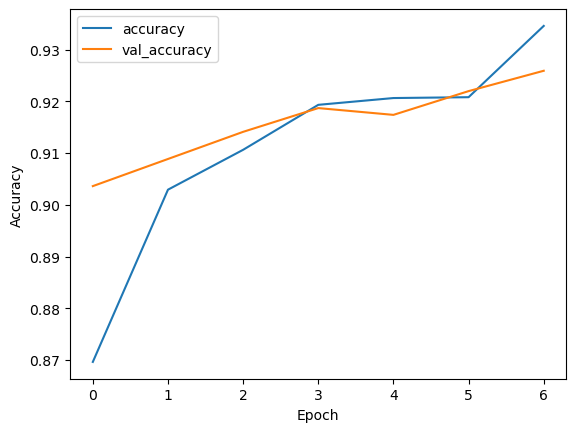

In [45]:
plt.plot(transfer_history.history['accuracy'], label='accuracy')
plt.plot(transfer_history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

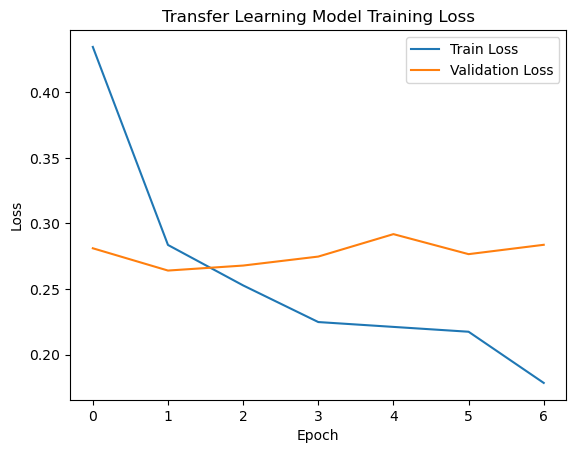

In [46]:
plt.plot(transfer_history.history['loss'], label='Train Loss')
plt.plot(transfer_history.history['val_loss'], label='Validation Loss')
plt.title('Transfer Learning Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Prediction on New Images

In [47]:

# Load the model
model = load_model('forgery_model.keras')

# Define the class names
class_names = ['Tampered', 'Authentic']

# Function to prepare image
def prepare_image(image_path):
    image = Image.open(image_path)
    image = np.array(image.resize((128, 128))) / 255.0
    return image.reshape(-1, 128, 128, 3)

# Path to the image you want to predict
image_path ="CASIA Dataset/prediction/Au_ani_0016.jpg"

# Prepare the image for prediction
image = prepare_image(image_path)

# Perform prediction
prediction = model.predict(image)
predicted_class = np.argmax(prediction)

# Get the confidence
confidence = np.amax(prediction) * 100

# Get the predicted class name
predicted_class_name = class_names[predicted_class]

# Print prediction result
print(f'Predicted Class: {predicted_class_name}')
print(f'Confidence: {confidence:.2f}%')


1/1 [==============================] - 0s 424ms/step
Predicted Class: Authentic
Confidence: 100.00%


In [48]:
# Load the model
model = load_model('Densenet_model.keras')

# Define the class names
class_names = ['Tampered', 'Authentic']

# Function to prepare image
def prepare_image(image_path):
    image = Image.open(image_path)
    image = np.array(image.resize((128, 128))) / 255.0
    return image.reshape(-1, 128, 128, 3)

# Path to the image you want to predict
image_path ="CASIA Dataset/prediction/Sp_D_CNN_R_art0027_art0066_0100.jpg"

# Prepare the image for prediction
image = prepare_image(image_path)

# Perform prediction
prediction = model.predict(image)
predicted_class = np.argmax(prediction)

# Get the confidence
confidence = np.amax(prediction) * 100

# Get the predicted class name
predicted_class_name = class_names[predicted_class]

# Print prediction result
print(f'Predicted Class: {predicted_class_name}')
print(f'Confidence: {confidence:.2f}%')


1/1 [==============================] - 3s 3s/step
Predicted Class: Tampered
Confidence: 99.97%


### CONCLUSION

In conclusion, This project successfully developed a deep learning-based system for detecting image forgery. By leveraging Convolutional Neural Networks and transfer learning techniques, we achieved accurate identification of tampered images. The project's outcomes demonstrate the practical significance of  approach in addressing challenges related to image manipulation, with potential applications in forensic investigations, media authentication, content verification, and security. Overall, our work highlights the effectiveness of deep learning frameworks in enhancing image integrity and authenticity verification processes.